# Práctica 3 - Ajuste de Modelos Lineales

### Alumno: MIGUEL GARCÍA LÓPEZ
### Grupo: A2

Límite de entrega: 5 de Junio de 2022 a las 23:59 (PRADO)

Valoración máxima: 12 puntos

#**2 -- (Regresión) --** 

#Análisis del problema
Este conjunto de datos es un subconjunto de 'Million Song Dataset'.

El dataset es cuestión es una colección de características de canciones y metadatos de un millón de temas populares.

Este dataset no incluye audio, solo características derivadas.

* X -> Los inputs de nuestro problemas son canciones las cuales están descompuestas en características tales como medias de timbre y covarianzas de timbres:
  * x = [90 atributos, 12 = medias de timbre, 78 = covarianzas de timbre]
* Y -> Los outputs esperados de nuestro problema, las etiquetas deseadas:
  * y = [año] (año de la canción, comprendido entre 1922 y 2011)
* F -> la función objetivo de nuestro problema sería una que dado unos datos X nos devolviera unas salidas Y con predicciones perfectas sobre si la canción en cuestión es del año que dice nuestro modelo.

In [1]:
# Librerías a utilizar
import pandas as pd
import math as mt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from numpy import nan
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import metrics
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clasificación
path = '/content/drive/My Drive/Colab Notebooks/datos3/res/YearPredictionMSD.txt'
 
# Función para lectura de datos
def readData(path):
  data = pd.read_csv(path, sep=',', header=None)
  return data

data = readData(path)

**(1)** Leemos los datos con la función readData. Esta función se encarga de leer un fichero txt gracias a las herramientas proporcionadas por la biblioteca "Pandas". Le pasamos como parámetros la dirección al archivo y un separador, en nuestro caso ','.

In [3]:
# Función para dividir los datos y sus etiquetas y dividir en train y test
def splitData(data):
  x = data.iloc[:,1:]
  y = data.iloc[:, 0]
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12345)
  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = splitData(data)
print("Tamaño de x_train: ",x_train.size)

Tamaño de x_train:  37104840


**(2)** Creamos una función que divide el dataframe en x (datos) e y (etiquetas). Después usamos la función de sklearn de train_test_split que nos divide los datos en entrenamiento y test. Le especificamos en los parámetros que queremos un tamaño de test del 20% del total de los datos y un valor random para mezclarlos que funciona como semilla, siempre que los mezclemos con ese valor se barajarán igual, por lo que nos resulta muy conveniente para comprobar mejoras y añadidos al código sin que intervenga el azar a la hora de barajar. Hemos utilizado un 20% para test debido a las siguientes razones:
* Si el tamaño del conjunto training es demasiado pequeño, nuestra hipótesis candidata será peor.
* Si el tamaño del conjunto test es muy pequeño, nuestra varianza se disparará.

Tenemos que obtener equilibrio, y como regla general podemos obtener una buena estimación fijando $K = \frac{N}{5}$ (20 % de datos para test). Más adelante definiremos el conjunto de validación con cross-validation y justificaremos su uso.

In [4]:
print("VISUALIZACIÓN DE LOS DATOS:\n")
display(x_train.describe())

VISUALIZACIÓN DE LOS DATOS:



,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
count,412276.000000,412276.000000,412276.000000,412276.000000,412276.000000,412276.000000,412276.000000,412276.000000,412276.000000,412276.000000,...,412276.000000,412276.000000,412276.000000,412276.000000,412276.000000,412276.000000,412276.000000,412276.000000,412276.000000,412276.000000
mean,43.386406,1.268276,8.647337,1.174547,-6.549225,-9.515874,-2.393178,-1.804235,3.742752,1.888451,...,15.712230,-73.477527,41.516596,37.991893,0.296307,17.802302,-26.280089,4.448936,19.975862,1.321454
std,6.065332,51.604269,35.265387,16.325868,22.867440,12.870251,14.577117,7.967911,10.576201,6.535430,...,32.100487,175.370611,122.216208,95.116857,16.141899,114.220531,174.185612,13.315511,185.980027,22.102492
min,1.749000,-337.092500,-301.005060,-149.962040,-181.953370,-81.794290,-188.214000,-68.404510,-126.479040,-41.631660,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-272.289050,-2678.193680,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,39.953057,-26.101460,-11.470458,-8.492973,-20.641762,-18.444392,-10.788185,-6.483562,-2.275515,-2.443828,...,-1.820833,-139.600430,-20.957477,-4.567147,-6.793785,-31.503952,-101.539158,-2.571710,-59.587065,-8.817493
50%,44.259925,8.378690,10.478560,-0.644750,-6.007530,-11.187325,-2.053475,-1.744090,3.835905,1.785125,...,9.123005,-53.208970,28.815010,33.640605,0.804600,15.672690,-21.158670,3.119280,7.645640,0.054450
75%,47.829145,36.112248,29.734752,8.816200,7.739600,-2.366900,6.522715,2.908455,9.966518,6.158185,...,26.197967,13.383987,89.588262,77.837187,8.452415,67.941085,52.437155,9.970685,86.250485,9.656190
max,61.970140,322.362790,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,60.345350,...,840.973380,4469.454870,3210.701700,1734.079690,242.089230,3662.065650,2833.608950,463.419500,7393.398440,677.899630


In [5]:
print("VISUALIZACIÓN DE LAS ETIQUETAS:\n")
display(y_train)

VISUALIZACIÓN DE LAS ETIQUETAS:



424360    2001
475048    2005
451237    1995
200323    1996
322297    1984
          ... 
347556    1981
395393    2005
392477    2009
77285     2004
217570    2009
Name: 0, Length: 412276, dtype: int64

HISTOGRAMAS PARA TRAIN ETIQUETAS



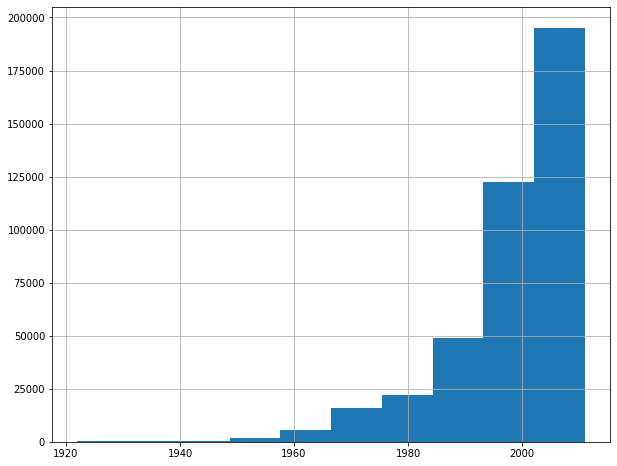


Año más alto en el train-set:  2011
Año más bajo en el train-set:  1922


In [6]:
plt.rcParams["figure.figsize"] = [10, 8]
print("HISTOGRAMAS PARA TRAIN ETIQUETAS\n")
y_train.hist()
plt.show()

print("\nAño más alto en el train-set: ", y_train.max())
print("Año más bajo en el train-set: ", y_train.min())

**(3)** El el visualizado de las etiquetas podemos observar cuantos ejemplos hay para cada año. Vemos que los ejemplos se concentran para el intervalo de año 1990-2011. De ahí hacia abajo los ejemplos son cada vez menos. Es posible que a la hora de eliminar outliers perdamos información de la década de 1920, siendo esta muy poco representativa del conjunto. Esto no es un problema como tal, porque si tan solo hay unos pocos ejemplos, el modelo no va a poder extraer información.

In [7]:
print("Cantidad de ejemplos por debajo de 1930:\n")
print(y_train[y_train <= 1930].value_counts())

Cantidad de ejemplos por debajo de 1930:

1929    66
1927    39
1928    37
1930    36
1926    15
1925     6
1922     5
1924     4
Name: 0, dtype: int64


**(4)** Como hemos dicho antes, y ahora podemos verlo, la cantidad de ejemplos sobre la década de los años 20 empieza a ser muy baja como para poder sér útil para el modelo.

BOXPLOTS



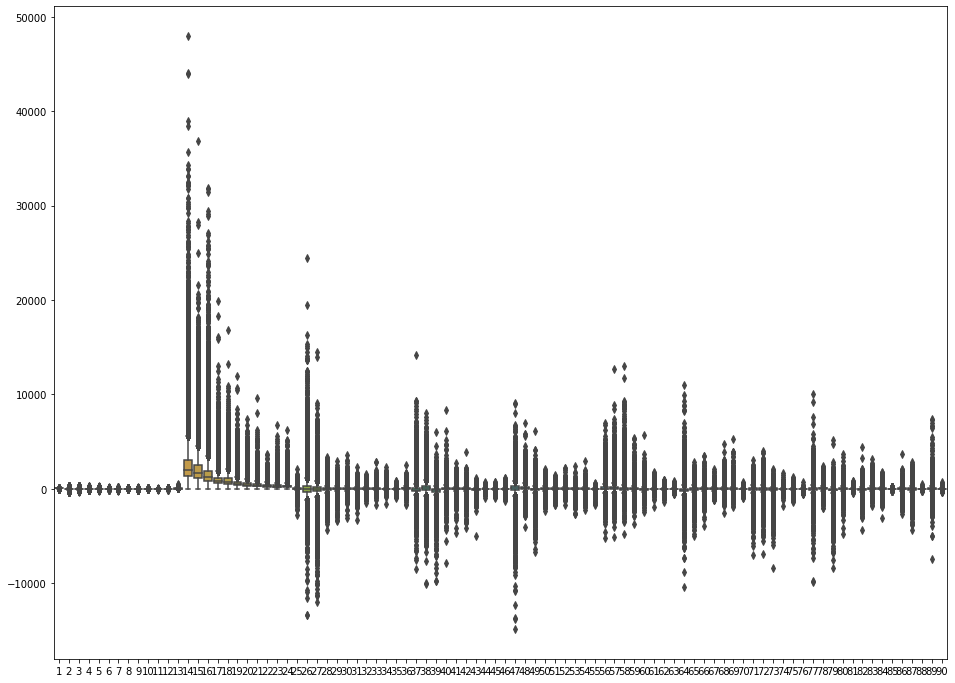

In [8]:
plt.rcParams["figure.figsize"] = [16, 12]
print("BOXPLOTS\n")
sns.boxplot(data=x_train)
plt.show()

**(4)** El gráfico de BoxPlot fue el que utilizamos en la anterior parte de la práctica referida a clasificación.

Podemos ver pues, que nuestros datos tienen claros outliers, los cuales serán manejados más adelante en el preprocesado de datos. Para ello utilizaremos IsolationForest. Esta función de sklearn se encarga de aislar observaciones seleccionando aleatoriamente una caraterística del conjunto de datos para después, aleatoriamente de nuevo, escoger un valor de particiṕon entre el máximo y el mínimo de esa característica.

Como la partición recursiva puede ser representada en forma de árbol, el número de particones para aislar una muestra es equivalente a la altura el árbol. Esta es la principal razón por la que uso esta función y no LOF (Local Outlier Factor), la cuál sí uso en clasificación. Esta vez la cantidad de datos es considerablemente mayor, por lo que por cuestiones de eficiencia en tiempo usaremos este algoritmo. Los resultados entre ambos algoritmos son muy equivalentes.

De igual manera que ocurría en clasificación, aquí eliminar outliers debe hacerse con cuidado y moviendonos en un rango de porcentaje de los datos muy bajo (5-1%).

In [ ]:
# Función para preprocesamiento de datos
def preProcData(c_datos,labels):

  c_datos = c_datos.join(labels)

  # Quitamos outliers
  iso = IsolationForest(contamination=0.01)
  outliers = iso.fit_predict(c_datos)

  # Eliminamos los datos que son considerados outliers (-1)
  c_datos = c_datos[outliers != -1]

  labels = c_datos.iloc[:,-1]
  c_datos = c_datos.iloc[:,:-1]
  
  # Los datos cuya variabilidad sea nula (0) serán eliminados
  selector = VarianceThreshold(threshold=0)
  c_datos = selector.fit_transform(c_datos)

  # Estandarizamos los datos
  scaler = StandardScaler()
  c_datos = scaler.fit_transform(c_datos)

  return c_datos, labels

before_outliers = x_train.shape[0]
print("Tamaño de x_train antes de preprocesado: ", before_outliers)
before_fet = x_train.shape[1]
print("Tamaño de características de x_train antes de preprocesado: ", before_fet)

x_train, y_train = preProcData(x_train, y_train)

after_outliers = x_train.shape[0]
print("Tamaño de x_train después de preprocesado: ", after_outliers)
after_fet = x_train.shape[1]
print("Tamaño de características x_train después de preprocesado: ", after_fet)

x_test, y_test = preProcData(x_test, y_test)

print("Porcentaje de valores outliers eliminados: ", (1-(after_outliers/before_outliers))*100, "%")
print("Año más alto en el train-set: ", y_train.max())
print("Año más bajo en el train-set: ", y_train.min())

Tamaño de x_train antes de preprocesado:  412276
Tamaño de características de x_train antes de preprocesado:  90


#Preprocesado de los datos
**(5)** Para el preprocesado de datos definimos una función a la que le pasamos los datos de train, le aplicamos las transformaciones necesarias y después hacemos lo mismo con los datos de test.

De nuevo para valorar la variabilidad de las características utilizo VarianceThreshold con un umbral de 0, es decir, cualquier característica que sea igual para todos los ejemplos es irrelevante y debería ser eliminada. Pese a ello, podemos observar que no se elimina ninguna, ni siquiera aumentando el umbral. Como conclusión podemos intuir que son todas igual de importantes a la hora de aportar información.

Para estandarizar usamos StandardScaler, cuyos resultados son muy superiores al resto probados. Como ya explicamos, estandarizar remueve la media y escala los datos a la varianza de la unidad. En el caso de regresión me ha dado unos resultados muy superiores a otros normalizadores/escaladores tales como MinMaxScaler, RobustScaler o QuantileTransformer. Estos dos últimos resultaban interesantes por el manejo que tienen de los outliers. Pese a ello he obtenido mejores resultados (no he hecho data snooping) con StandarScaler y el manejo de los outliers con IsolationForest.

Como podemos ver, la herramienta de selección de outliers nos elimina un 2% de contaminación como le hemos indicado. De ese 2% ha eliminado ejemplos de varias épocas, pese a ello la década de los años 20 sigue estando representada. Si aumentásemos el porcentaje de contaminación llevaría a eliminar varios años de los menos representados.

In [ ]:
# Hacemos la selección de hiperparámetros usando cross validation para LR
def featureSelectionR(x_train,y_train,folds,s):
    parameters = [{'penalty':['l1','l2'],'alpha':[0.1,0.01,0.001,0.0001,0.00001],'epsilon':[0.1]}]
    linear_regression = linear_model.SGDRegressor(early_stopping=True,n_iter_no_change=1,max_iter=1000)
    g_ = GridSearchCV(linear_regression, parameters, cv=folds, scoring=s)
    g_.fit(x_train,y_train)
    predictions = g_.predict(x_train)
    print("Logistic-regression:\n----------------")
    print("Hiperparámetros: ", g_.best_params_)
    if s == 'neg_mean_absolute_error':
      print("Mean Absolute Error: ", metrics.mean_absolute_error(y_train,predictions))
    else:
      print("Mean Squared Error: ", metrics.mean_squared_error(y_train,predictions))
    return g_

# Hacemos la selección de hiperparámetros usando cross validation para Dummy
def featureSelectionD(x_train,y_train,folds,s):
    parameters = [{'strategy':['mean']}]
    dummy = DummyRegressor()
    g_ = GridSearchCV(dummy, parameters, cv=folds, scoring=s)
    g_.fit(x_train,y_train)
    predictions = g_.predict(x_train)
    print("Logistic-regression:\n----------------")
    print("Hiperparámetros: ", g_.best_params_)
    print("Mean Squared Error: ", metrics.mean_squared_error(y_train,predictions))
    return g_

# DESCOMENTAR PARA PROBAR DIFERENTES K PARA CV
#for i in range(5,11):
#  print("\n----CROSS-VALIDATION PARA ", i, " PARTICIONES----")
#  best_model_MAE = featureSelectionR(x_train,y_train,i,'neg_mean_absolute_error')
#  best_model_MSE = featureSelectionR(x_train,y_train,i,'neg_mean_squared_error')

best_model_MAE = featureSelectionR(x_train,y_train,5,'neg_mean_absolute_error')
best_model_MSE = featureSelectionR(x_train,y_train,5,'neg_mean_squared_error')
best_model_Dummy = featureSelectionR(x_train,y_train,5,'neg_mean_squared_error')

# Hacemos test para R
def LinealRegression(x_train, y_train, x_test, y_test, best_model):
  g = linear_model.SGDRegressor(**best_model.best_params_).fit(x_train, y_train)
  predictions = g.predict(x_test)
  score = g.score(x_test,y_test)

  print("E_test: ", score)
  return g, predictions, score


print("\n\n----------- RESULTADOS CONJUNTO TEST -----------\n\n")

model_MSE, predictions_MSE, etest = LinealRegression(x_train, y_train, x_test, y_test, best_model_MSE)

#Formulación hipótesis y entrenamiento
**(6)** A la hora de hacer selección de modelos vamos a usar de nuevo GridSearchCV para la búsqueda exhaustiva de hiperparámetros:
* Penalty (regularizador): volvemos a tener en cuenta los dos regularizadores, que son Lasso y Ridge.

  * Regularizador Lasso (l1): este tipo de regularizacin minimiza la siguiente expresión:

  $min_{w,c}\frac{1}{2}w^Tw+C\sum_{i=1}^{N}log(exp(-y_i(X_i^Tw+c))+1).$   
  
  Esta es efectiva cuando los atributos de entrada sean irrelevantes o así lo sospechemos, pues algunos coeficientes pueden acabar valiendo 0. De esta forma tendremos solo algunos atributos relevantes, nuestra complejidad será mejor y tendremos una mejor generalización. Funciona mejor cuando no hay demasiada relación entre atributos.
  * Regularizador Ridge (l2): se minimiza la siguiente expresión:

  $min_{w,c}||w||_1+C\sum_{i=1}^{N}log(exp(-y_i(X_i^Tw+c))+1).$ 

  Esta se suele utilizar cuando, al contrario que en l1 (lasso), sospechamos que los atributos si tienen conexiones más fuertes entre ellos. Ridge se encarga de minimizar los coeficientes.

* Alpha (cantidad de regularización): aplicamos distintas cantidades para ver cuáles dan mejor resultados.
* Epsilon: determina un umbral para la función de perdida, en nuestro caso squared-error (por defecto, no hace falta indicarla).

Dentro de la función GridSearchCV que realiza el cross-validation para la estimación de los hiperparámetros se encuentra el estimador (nuestro algoritmo de regresión), los parámetros a estimar, número de folds para cross validaton (por defecto se aplica Stratified, lo cuál indica que se presevar en cada fold el porcentaje de ejemplos por clase), y el parámetro scoring, al cual debemos pasarle el tipo de métrica que decidirá que modelo es más prometedor según nuestros intereses.

Como parámetros estáticos hemos seleccionado que nuestro modelo debe tener earlystopping en el momento de aprendizaje. Este parámetro indica que tras unas cuantas épocas sin mejorar el algoritmo deberá parar. El número de épocas viene determinado por n_iter_no_change. Estos dos últimos son sobre todo por cuestiones de tiempo, ya que el algoritmo podía tardar muchos minutos y arrojar una solución igual de buena que con earlystopping (de hecho tras varias ejecuciones, es así, de ahí la elección de épocas = 1).

Otros parámetros utilizados son la función de pérdida, en nuestro caso 'squared_error' ya que usamos regresión lineal, 'tol' el cual hace referencia al criterio de parada, si es distinto de 'None' el entrenamiento parará cuando (loss > best_loss - tol) siendo la tolerancia por defecto 1e-3. También tenemos el learning rate y eta0 (el learning rate inicial). El tipo de learning rate por defecto es el adaptativo, el cual decrece a medida que pasa el entrenamiento.

The stopping criterion. If it is not None, training will stop when (loss > best_loss - tol) for n_iter_no_change consecutive epochs. Convergence is checked against the training loss or the validation loss depending on the early_stopping parameter.

Como métrica de evaluación vamos a probrar dos, el error absoluto medio y el error cuadrático medio. El MSE es la distancia cuadrática media entre los valores observados y los predichos. La interpretación es menos intuitiva que en el error medio absoluto. Este tipo de métrica penaliza los errores grandes mucho más que los pequeños, por lo que se suele utilizar cuando interesa que tu modelo tenga errores pequeños.

* $MSE = \frac{1}{n}\sum_{i=1}^{n}(Y_i-\hat{Y}_i)^2$

El MAE (mean absolute error) mide la media de todos los errores absolutos. Un error absoluto es la cantidad de error en nuestra medida, por ejemplo, si nuestro modelo a partir de cierta información da como salida que la canción pertenece a 2007 y la respuesta verdadera es que es de 2001. En ese caso, nuestro error absoluto será de 6.

* $MAE = \frac{1}{n}\sum_{i=1}^{n}|Y_i-\hat{Y}_i|$

Este tipo de error es fácilmente interpretable por lo que nos ayudará a la hora de realizar un análisis de los resultados.

Hemos usado 5 folds dado que los resultados arrojados en pruebas son muy equivalentes y no hay diferencia apreciable, además el tiempo para 5 folds es inferior.

#Discusión de los resultados
**(7)** Podemos ver en los resultados arrojados por 5-fold cross validation que nuestro modelo MAE tiene un error medio de 6.8, esto significa que de media nuestro modelo se ha equivocado con una diferencia de 6.8 años con respecto a el año verdadero. En caso de MSE el error es cuadrático, es normal que sea mucho mayor en valor absoluto. Esta métrica, como hemos explicado antes, penaliza los errores muy grandes. En nuestro caso es algo que nos interesa, si nuestro clasificador predijera una canción del 2011 como una del 1985, sería un caso para nada interesante. En cambio, podemos soportar errores más pequeños, de menos años de diferencia. Por ello a pesar de que el error dado por MSE sea mayor de media comparado con MAE ($\sqrt{MAE} > MSE)$, creo que vale la pena sacrificar algo de precisión por un modelo más estable y con errores menores en vez de tener uno que de media predice mejor, pero que fuede tener errores muy grandes ocasionalmente.

In [ ]:
eout = etest + mt.sqrt(mt.log(2/0.05)/(2*x_test.shape[0]))
print("Estimación Eout: ", eout)

**(8)** Sabiendo que $E_{test}$ es una buena cota para $E_{out}$ podemos asegurar con seguridad que el error fuera de la muestra será siempre:
  
  * $E_{out}(g)\leq E_{test}(g) + \sqrt{\frac{1}{2N}ln \frac{2}{α}}$

Dado esta fórmula calculamos la cota para el error fuera de la muestra. En este caso la variable $α=0.05$ indica que la cota es esa para una confianza del 95%.

In [ ]:
def createLearningCurvesR(x_train, y_train, model):
  X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=12345)

  ein = []
  eout = []
  N = []
  alpha = 0.0005
  j = round(X_train.shape[0] * alpha)

  for i in range(X_train.shape[0]):
    predictions = model.predict(X_train[i:j])
 
    score = metrics.mean_squared_error(Y_train[i:j],predictions)
    ein.append(score)

    predictions = model.predict(X_val[i:j])
  
    score = metrics.mean_squared_error(Y_val[i:j],predictions)
    eout.append(score)
    N.append(j)

    alpha += 0.0005
    i = j + 1

    if i >= X_train.shape[0]:
      break

    if (j + round(X_train.shape[0] * alpha)) < X_train.shape[0]:
      j = j + round(X_train.shape[0] * alpha)
    else:
      j = X_train.shape[0]

  return ein, eout, N

einMSE, eoutMSE, N = createLearningCurvesR(x_train, y_train, model_MSE)

In [ ]:
def learning_curves(ein, eout, N):
  plt.figure(figsize=(7,7))
  x1 = N
  y1 = ein
  x2 = N
  y2 = eout

  plt.plot(x1, y1, c = 'b', label = "E_in")
  plt.plot(x2, y2, c = 'r', label = "E_val")
  plt.xlabel("Number of data points, N")
  plt.ylabel("Error")
  plt.legend()

  plt.show()

print("---- LEARNING CURVES R ----")
print("\nMSE: \n")
learning_curves(einMSE, eoutMSE, N)

**(9)** Analizando las curvas de aprendizaje de nuestro modelo de regresión lineal podemos observar como la curva del error dentro de la muestra (dentro del training set) aumenta al principio para terminar estabilizandose. Con validación ocurre lo mismo, y podemos observar como ambas curvas se aproximan una a la otra. Esto es porque el error in sample (si N es suficientemente grande) es muy probable que sea cercano al error out of sample (debido a la desigualdad de Hoeffding). 

  * $P[|E_{in} - E_{out}| > ε] \leq 2e^{-2ε^2N}$

Estas curvas indican un proceso de aprendizaje y como a medida que el tamaño de la población aumenta, nuestros errores disminuyen de forma gradual hasta estabilizarse.

#Empresa
**(17)** Si fuese una persona dentro de una empresa a la que le han encargado realizar este ajuste sin distinción entre training y test debería tener varias cosas en cuenta.

Tenemos que saber lo que implica usar un conjunto de validación, y es que el conjunto de validación es casi idéntico al conjunto de test. Retiramos un subconjunto de los datos que no es usado en training y luego lo utilizamos para testar los resultados y estimar $E_{out}$. A pesar de que este conjunto no se usa en el training, sí que influye en cierta medida en el proceso de entrenamiento, pero lo hace de manera tan benigna que Eout apenas se ve afectado, por lo que es una buena manera de estimar $E_{out}$.

Pese a ello, también hay que tener en cuenta el tamaño del conjunto de validación. Como ya comentamos en la división de datos si el tamaño del conjunto training es demasiado pequeño (conjunto de validación muy grande), nuestra hipótesis candidata será peor pues tiene menos datos para entrenarse. Por el contrario, si el tamaño del conjunto validación es muy pequeño, nuestra varianza se disparará.

Por ello estimar un tamaño adecuado es crucial para la buena selección de nuestro modelo.

Otra cosa a tener en cuenta es no usar los datos de validación/test para absolutamente nada. Si los usasemos para el análisis cabría la posibilidad de estar guiando nuestras decisiones para adaptar el modelo lo mejor posible a esos datos, pero, ¿cuando lleguen el resto de muestras?. Nuestro modelo debe saber generalizar, no podemos adaptarlo a una muestra concreta. Mucho menos deberíamos validar con los mismos datos que entrenamos, estaríamos estimando un error muy optimista, lo cual no será ni mucho menos preciso a la hora de usarlo fuera de la muestra de entrenamiento. 

El $E_{out}$ dado debería ser una cota de este, garantizando que nunca superará este umbral. Por ello, si calculamos $E_{test}$ podríamos tener también una estimación realista del error fuera de muestra, como hemos hecho antes al estimarlo en apartados anteriores.